# One-Class Classification for Outlier Detection in Colon Segmentation

This notebook analyzes component statistics from colon segmentation data to identify outliers using Isolation Forest and One-Class SVM. It visualizes the distributions, applies outlier detection, and prepares stratified train/test splits for further analysis or model development.

### Data exploration

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns

In [83]:
component_statistics_nc = pd.read_csv('data/component_statistics_nc.csv')
component_statistics_saLabels = pd.read_csv('data/component_statistics_sa-labels.csv')

In [84]:
# Group by 'Filename' and calculate the sum for 'Volume', 'Component', and 'Centerline Length'
grouped_collapsed = component_statistics_saLabels.groupby('Filename').agg(
    total_volume=('Volume', 'sum'),
    total_components=('Component', 'sum'),
    total_centerline_length=('Centerline Length', 'sum')
).reset_index()

grouped_non_collapsed = component_statistics_nc.groupby('Filename').agg(
    total_volume=('Volume', 'sum'),
    total_components=('Component', 'sum'),
    total_centerline_length=('Centerline Length', 'sum')
).reset_index()

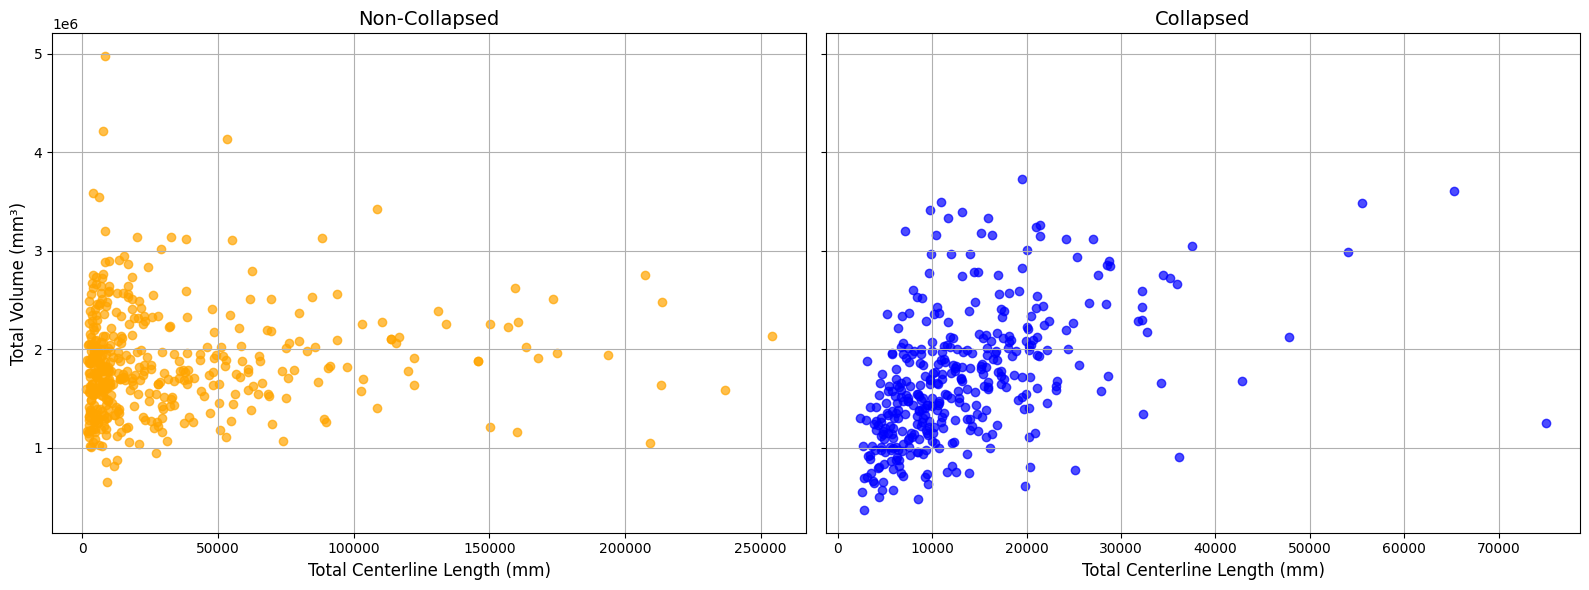

In [85]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Scatter plot for non-collapsed data
axes[0].scatter(
    grouped_non_collapsed['total_centerline_length'], 
    grouped_non_collapsed['total_volume'], 
    color='orange', 
    alpha=0.7
)
axes[0].set_xlabel('Total Centerline Length (mm)', fontsize=12)
axes[0].set_ylabel('Total Volume (mm³)', fontsize=12)
axes[0].set_title('Non-Collapsed', fontsize=14)
axes[0].grid(True)

# Scatter plot for collapsed data
axes[1].scatter(
    grouped_collapsed['total_centerline_length'], 
    grouped_collapsed['total_volume'], 
    color='blue', 
    alpha=0.7
)
axes[1].set_xlabel('Total Centerline Length (mm)', fontsize=12)
axes[1].set_title('Collapsed', fontsize=14)
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [86]:
# Mean values
mean_collapsed = grouped_collapsed[['total_volume', 'total_centerline_length']].mean()
mean_non_collapsed = grouped_non_collapsed[['total_volume', 'total_centerline_length']].mean()

# Print mean values without scientific notation
print("Mean values for collapsed data:")
print(mean_collapsed.apply(lambda x: f"{x:,.2f}"))  # Format with commas and 2 decimal places

print("Mean values for non-collapsed data:")
print(mean_non_collapsed.apply(lambda x: f"{x:,.2f}"))  # Format with commas and 2 decimal places

Mean values for collapsed data:
total_volume               1,697,962.62
total_centerline_length       13,319.40
dtype: object
Mean values for non-collapsed data:
total_volume               1,859,580.00
total_centerline_length       31,965.68
dtype: object


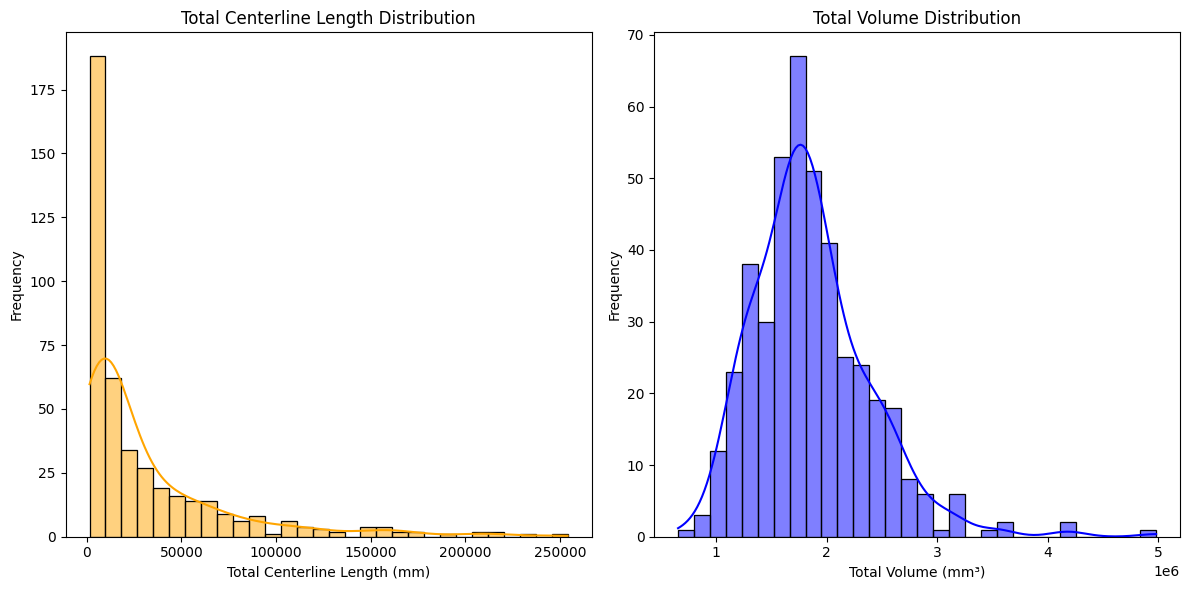

Shapiro-Wilk Test Results:
Total Centerline Length: W=0.6862, p=0.0000
Total Volume: W=0.9371, p=0.0000
Total Centerline Length does not follow a Gaussian distribution (reject H0).
Total Volume does not follow a Gaussian distribution (reject H0).


In [87]:


# Extract the columns to test
lengths = grouped_non_collapsed['total_centerline_length']
volumes = grouped_non_collapsed['total_volume']

# Plot histograms for visual inspection
plt.figure(figsize=(12, 6))

# Histogram for total_centerline_length
plt.subplot(1, 2, 1)
sns.histplot(lengths, kde=True, color='orange', bins=30)
plt.title('Total Centerline Length Distribution')
plt.xlabel('Total Centerline Length (mm)')
plt.ylabel('Frequency')

# Histogram for total_volume
plt.subplot(1, 2, 2)
sns.histplot(volumes, kde=True, color='blue', bins=30)
plt.title('Total Volume Distribution')
plt.xlabel('Total Volume (mm³)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Perform Shapiro-Wilk test for normality
print("Shapiro-Wilk Test Results:")
stat_length, p_length = shapiro(lengths)
stat_volume, p_volume = shapiro(volumes)

print(f"Total Centerline Length: W={stat_length:.4f}, p={p_length:.4f}")
print(f"Total Volume: W={stat_volume:.4f}, p={p_volume:.4f}")

# Interpret the results
alpha = 0.05
if p_length > alpha:
    print("Total Centerline Length follows a Gaussian distribution (fail to reject H0).")
else:
    print("Total Centerline Length does not follow a Gaussian distribution (reject H0).")

if p_volume > alpha:
    print("Total Volume follows a Gaussian distribution (fail to reject H0).")
else:
    print("Total Volume does not follow a Gaussian distribution (reject H0).")

### Isolation Forest

In [88]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

In [89]:
# Prepare the data
features = ['total_centerline_length', 'total_volume']
X_non_collapsed = grouped_non_collapsed[features]

# Scale the data
scaler = StandardScaler()
X_non_collapsed_scaled = scaler.fit_transform(X_non_collapsed)

# Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination='auto', random_state=42)  # Adjust contamination as needed
y_pred = iso_forest.fit_predict(X_non_collapsed_scaled)  # 1 = inlier, -1 = outlier

# Add the predictions to the DataFrame
grouped_non_collapsed['is_inlier'] = (y_pred == 1).astype(int)  # 1 = inlier, 0 = outlier

# Filter inliers
filtered_non_collapsed = grouped_non_collapsed[grouped_non_collapsed['is_inlier'] == 1]

# Print results
print(f"Original non-collapsed data: {len(grouped_non_collapsed)} rows")
print(f"Filtered non-collapsed data (inliers): {len(filtered_non_collapsed)} rows")

Original non-collapsed data: 432 rows
Filtered non-collapsed data (inliers): 362 rows


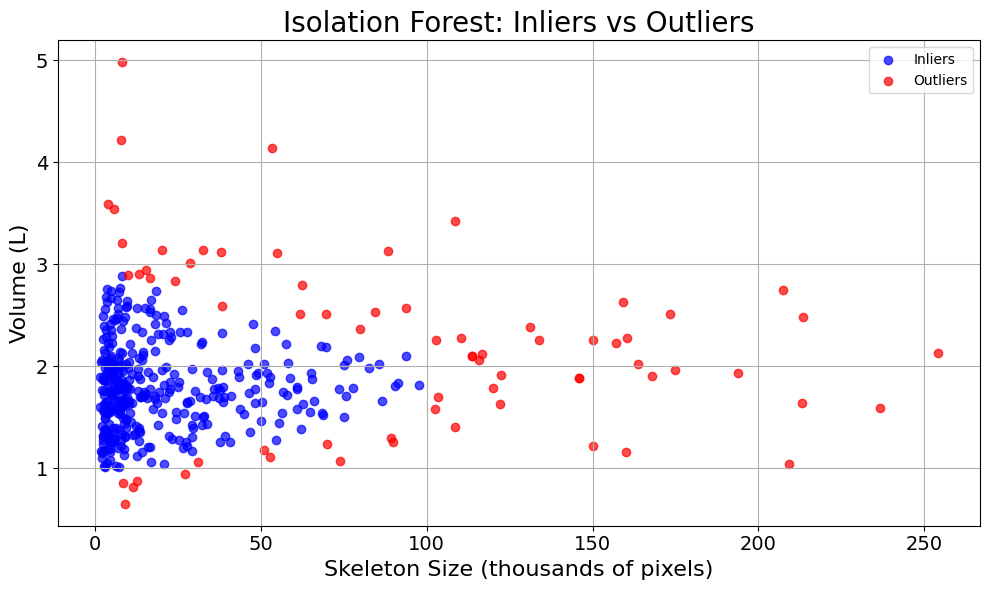

In [90]:
# Convert volume from mm³ to liters
grouped_non_collapsed['total_volume_liters'] = grouped_non_collapsed['total_volume'] / 1e6

# Convert skeleton length (number of pixels) to thousands of pixels
grouped_non_collapsed['total_centerline_length_k'] = grouped_non_collapsed['total_centerline_length'] / 1000

# Scatter plot of the data with inliers and outliers
plt.figure(figsize=(10, 6))

# Plot inliers
inliers = grouped_non_collapsed[grouped_non_collapsed['is_inlier'] == 1]
plt.scatter(
    inliers['total_centerline_length_k'],
    inliers['total_volume_liters'],  # Use the converted volume
    color='blue',
    label='Inliers',
    alpha=0.7
)

# Plot outliers
outliers = grouped_non_collapsed[grouped_non_collapsed['is_inlier'] == 0]
plt.scatter(
    outliers['total_centerline_length_k'],
    outliers['total_volume_liters'],  # Use the converted volume
    color='red',
    label='Outliers',
    alpha=0.7
)

# Add labels and legend
plt.xlabel('Skeleton Size (thousands of pixels)', fontsize=16)  # Updated label
plt.ylabel('Volume (L)', fontsize=16)  # Updated to reflect volume in liters
plt.title('Isolation Forest: Inliers vs Outliers', fontsize=20)
plt.legend()

# Increase tick font size
plt.tick_params(axis='both', which='major', labelsize=14)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=12)  # Minor ticks (if any)

plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
# median volume of inlier
median_volume = grouped_non_collapsed[grouped_non_collapsed['is_inlier'] == 1]['total_volume_liters'].mean()
print(f"Median volume of inliers: {median_volume:.2f} L")

std_volume = grouped_non_collapsed[grouped_non_collapsed['is_inlier'] == 1]['total_volume_liters'].std()
print(f"Standard deviation of inlier volumes: {std_volume:.2f} L")

# mean skeleton size
mean_skeleton_size = grouped_non_collapsed[grouped_non_collapsed['is_inlier'] == 1]['total_centerline_length_k'].mean()
print(f"Mean skeleton size of inliers: {mean_skeleton_size:.2f} thousands of pixels")
# standard deviation skeleton size
std_skeleton_size = grouped_non_collapsed[grouped_non_collapsed['is_inlier'] == 1]['total_centerline_length_k'].std()
print(f"Standard deviation of skeleton sizes of inliers: {std_skeleton_size:.2f} thousands of pixels")

Median volume of inliers: 1.79 L
Standard deviation of inlier volumes: 0.40 L
Mean skeleton size of inliers: 19.88 thousands of pixels
Standard deviation of skeleton sizes of inliers: 20.98 thousands of pixels


/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_88578/2525982434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_non_collapsed['total_volume_liters'] = filtered_non_collapsed['total_volume'] / 1e6
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_88578/2525982434.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_non_collapsed['total_centerline_length_k'] = filtered_non_collapsed['total_centerline_length'] / 1e3


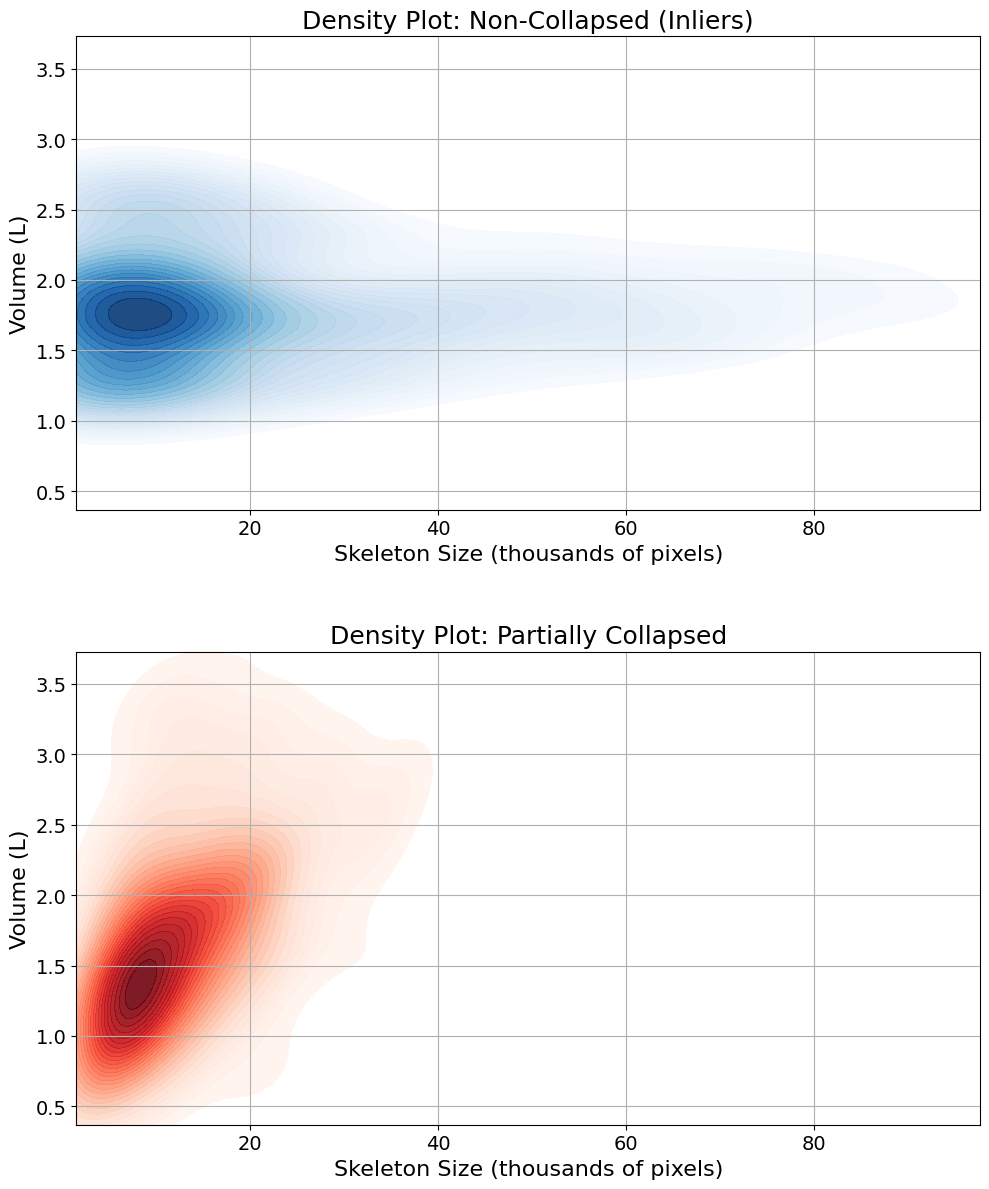

In [93]:
# Filter inliers for non-collapsed data
filtered_non_collapsed = grouped_non_collapsed[grouped_non_collapsed['is_inlier'] == 1]

# Convert y-axis values from mm³ to liters
filtered_non_collapsed['total_volume_liters'] = filtered_non_collapsed['total_volume'] / 1e6
grouped_collapsed['total_volume_liters'] = grouped_collapsed['total_volume'] / 1e6

# Convert x-axis values (centerline length) from mm to thousands of pixels
filtered_non_collapsed['total_centerline_length_k'] = filtered_non_collapsed['total_centerline_length'] / 1e3
grouped_collapsed['total_centerline_length_k'] = grouped_collapsed['total_centerline_length'] / 1e3

# Determine the common x and y limits
x_min = min(filtered_non_collapsed['total_centerline_length_k'].min(), grouped_collapsed['total_centerline_length_k'].min())
x_max = max(filtered_non_collapsed['total_centerline_length_k'].max(), grouped_collapsed['total_centerline_length_k'].max())
y_min = min(filtered_non_collapsed['total_volume_liters'].min(), grouped_collapsed['total_volume_liters'].min())
y_max = max(filtered_non_collapsed['total_volume_liters'].max(), grouped_collapsed['total_volume_liters'].max())

# Create a figure with two subplots (stacked vertically)
plt.figure(figsize=(10, 12))

# Density plot for filtered non-collapsed data
plt.subplot(2, 1, 1)
sns.kdeplot(
    data=filtered_non_collapsed,
    x='total_centerline_length_k',
    y='total_volume_liters',
    fill=True,
    cmap='Blues',
    levels=30,
    alpha=0.9
)
plt.title('Density Plot: Non-Collapsed (Inliers)', fontsize=18)
plt.xlabel('Skeleton Size (thousands of pixels)', fontsize=16)
plt.ylabel('Volume (L)', fontsize=16)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)

# Density plot for collapsed data
plt.subplot(2, 1, 2)
sns.kdeplot(
    data=grouped_collapsed,
    x='total_centerline_length_k',
    y='total_volume_liters',
    fill=True,
    cmap='Reds',
    levels=30,
    alpha=0.9
)
plt.title('Density Plot: Partially Collapsed', fontsize=18)
plt.xlabel('Skeleton Size (thousands of pixels)', fontsize=16)
plt.ylabel('Volume (L)', fontsize=16)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout and increase the gap between plots
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Increase the gap between the plots

plt.show()

### One-class SVM

In [94]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

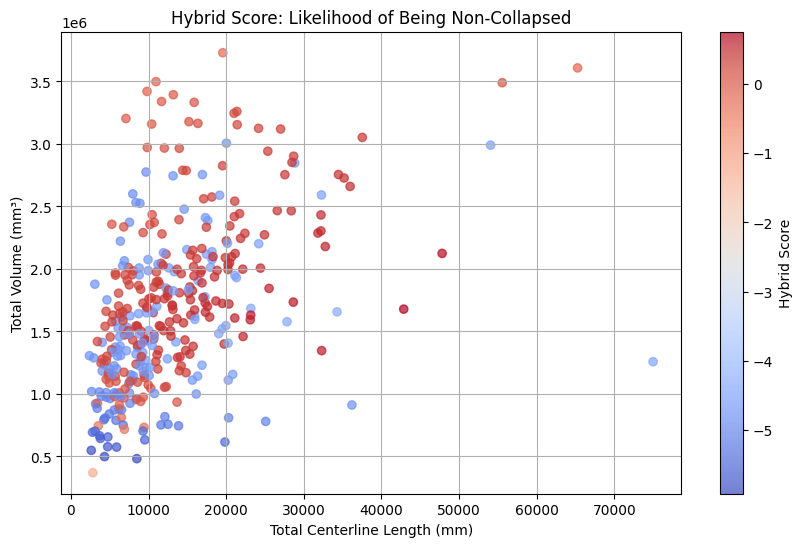

In [95]:

# Prepare the data
train_features = ['total_centerline_length', 'total_volume']  # exclude total_components for training
test_features = ['total_centerline_length', 'total_volume']  # same for scaling

X_non_collapsed = grouped_non_collapsed[train_features]
X_collapsed = grouped_collapsed[test_features]

# Scale the data
scaler = StandardScaler()
X_non_collapsed_scaled = scaler.fit_transform(X_non_collapsed)
X_collapsed_scaled = scaler.transform(X_collapsed)

# Train the One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)
oc_svm.fit(X_non_collapsed_scaled)

# Predict and score collapsed data
svm_raw_scores = oc_svm.decision_function(X_collapsed_scaled)  # Higher = more normal
y_pred_collapsed = oc_svm.predict(X_collapsed_scaled)  # 1 = inlier, -1 = outlier

# Apply hybrid scoring (penalize if total_components > 1)
penalty = -5.0 
component_counts = grouped_collapsed['total_components']
component_penalty = (component_counts > 1).astype(float) * penalty
hybrid_scores = svm_raw_scores + component_penalty

# Update the collapsed data
grouped_collapsed['anomaly'] = y_pred_collapsed
grouped_collapsed['svm_score'] = svm_raw_scores
grouped_collapsed['hybrid_score'] = hybrid_scores
grouped_collapsed['hybrid_anomaly'] = (hybrid_scores >= 0).astype(int)  # 1 = likely non-collapsed

# Visualize hybrid scores
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_collapsed['total_centerline_length'],
    X_collapsed['total_volume'],
    c=hybrid_scores,
    cmap='coolwarm',
    alpha=0.7
)
plt.xlabel('Total Centerline Length (mm)')
plt.ylabel('Total Volume (mm³)')
plt.title('Hybrid Score: Likelihood of Being Non-Collapsed')
plt.colorbar(scatter, label='Hybrid Score')
plt.grid(True)
plt.show()


/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_88578/3489815139.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inliers['total_volume_liters'] = inliers['total_volume'] / 1e6
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_88578/3489815139.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_one_component['total_volume_liters'] = outliers_one_component['total_volume'] / 1e6
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_88578/3489815139.py:13: SettingWithCopy

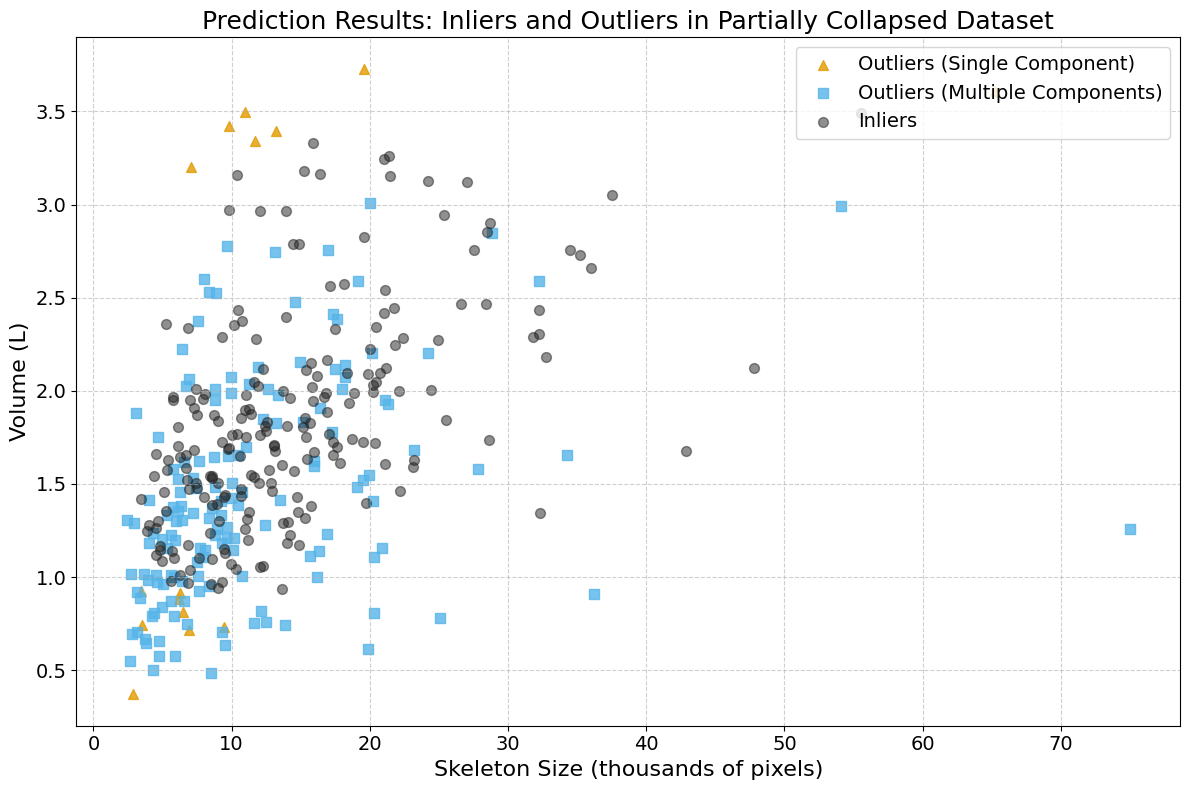

In [96]:
# Filter data
inliers = grouped_collapsed[grouped_collapsed['hybrid_anomaly'] == 1]
outliers_one_component = grouped_collapsed[
    (grouped_collapsed['hybrid_anomaly'] == 0) & (grouped_collapsed['total_components'] == 1)
]
outliers_more_than_one_component = grouped_collapsed[
    (grouped_collapsed['hybrid_anomaly'] == 0) & (grouped_collapsed['total_components'] > 1)
]

# Convert y-axis values from mm³ to liters
inliers['total_volume_liters'] = inliers['total_volume'] / 1e6
outliers_one_component['total_volume_liters'] = outliers_one_component['total_volume'] / 1e6
outliers_more_than_one_component['total_volume_liters'] = outliers_more_than_one_component['total_volume'] / 1e6

# Convert x-axis values (centerline length) from mm to thousands of pixels
inliers['total_centerline_length_k'] = inliers['total_centerline_length'] / 1e3
outliers_one_component['total_centerline_length_k'] = outliers_one_component['total_centerline_length'] / 1e3
outliers_more_than_one_component['total_centerline_length_k'] = outliers_more_than_one_component['total_centerline_length'] / 1e3

# Define a colorblind-friendly palette: inliers grey, outliers colorful
colors = {
    'Inliers': "#202020",                # Grey
    'Outliers (1 Component)': "#E29B00", # Orange (colorblind-friendly)
    'Outliers (>1 Component)': '#56B4E9' # Sky blue (colorblind-friendly)
}

plt.figure(figsize=(12, 8))

# Plot outliers with 1 component (orange, triangle)
plt.scatter(
    outliers_one_component['total_centerline_length_k'],
    outliers_one_component['total_volume_liters'],
    color=colors['Outliers (1 Component)'],
    alpha=0.8,
    s=50,
    label='Outliers (Single Component)',
    marker='^'  # Triangle
)

# Plot outliers with more than 1 component (blue, square)
plt.scatter(
    outliers_more_than_one_component['total_centerline_length_k'],
    outliers_more_than_one_component['total_volume_liters'],
    color=colors['Outliers (>1 Component)'],
    alpha=0.8,
    s=50,
    label='Outliers (Multiple Components)',
    marker='s'  # Square
)

# Plot inliers (grey, circle)
plt.scatter(
    inliers['total_centerline_length_k'],
    inliers['total_volume_liters'],
    color=colors['Inliers'],
    alpha=0.5,
    s=50,
    label='Inliers',
    marker='o'  # Circle
)

plt.xlabel('Skeleton Size (thousands of pixels)', fontsize=16)
plt.ylabel('Volume (L)', fontsize=16)
plt.title('Prediction Results: Inliers and Outliers in Partially Collapsed Dataset', fontsize=18)
plt.legend(fontsize=14, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

In [97]:
print(f"Number of inliers: {len(inliers)}")
print(f"Number of outliers (1 component): {len(outliers_one_component)}")
print(f"Number of outliers (>1 component): {len(outliers_more_than_one_component)}")

outliers_more_than_one_component = grouped_collapsed[
    (grouped_collapsed['hybrid_anomaly'] == 0) & (grouped_collapsed['total_components'] > 1)
]
# Find indices where hybrid_anomaly == 0 (outlier after penalty) and anomaly == 1 (inlier before penalty)
became_outlier_due_to_penalty = grouped_collapsed[
    (grouped_collapsed['hybrid_anomaly'] == 0) &
    (grouped_collapsed['anomaly'] == 1) &
    (grouped_collapsed['total_components'] > 1)
]

print(f"Number of outliers (>1 component) that were not outliers before penalty: {len(became_outlier_due_to_penalty)}")

Number of inliers: 206
Number of outliers (1 component): 15
Number of outliers (>1 component): 149
Number of outliers (>1 component) that were not outliers before penalty: 116


### Create train and test sets

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [99]:
# remove rows assumed to be inliners
svm_train_scores = oc_svm.decision_function(X_non_collapsed_scaled)

print(f"Training score range: {svm_train_scores.min():.4f} to {svm_train_scores.max():.4f}")
print(f"75th percentile (very normal): {np.percentile(svm_train_scores, 75):.4f}")
print(f"Median score: {np.median(svm_train_scores):.4f}")
print(f"Max score: {np.max(svm_train_scores):.4f}")

grouped_collapsed_filtered = grouped_collapsed[grouped_collapsed['hybrid_score'] < np.median(svm_train_scores)]

Training score range: -3.1847 to 0.8122
75th percentile (very normal): 0.5757
Median score: 0.3327
Max score: 0.8122


In [100]:
# Extract subject from the filename and add it as a column
grouped_collapsed_filtered['subject'] = grouped_collapsed_filtered['Filename'].str.extract(r'^(\d+)_')[0]
grouped_collapsed_filtered['position'] = grouped_collapsed_filtered['Filename'].str.extract(r'_pos-([a-zA-Z]+)_')[0]

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_88578/4287877045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_collapsed_filtered['subject'] = grouped_collapsed_filtered['Filename'].str.extract(r'^(\d+)_')[0]
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_88578/4287877045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_collapsed_filtered['position'] = grouped_collapsed_filtered['Filename'].str.extract(r'_pos-([a-zA-Z]+)_')[0]


In [101]:
df = grouped_collapsed_filtered.copy()

# Step 1: Assign scan_order based on position
position_order = {'prone': 1, 'supine': 2}
df['scan_order'] = df['position'].map(position_order)

# Step 2: Component status per scan
df['comp_status'] = df['total_components'].apply(lambda x: '1comp' if x == 1 else '>1comp')

# Step 3: Bin hybrid_score
df['score_bin'] = pd.qcut(df['hybrid_score'], q=3, labels=False, duplicates='drop')

# Step 4: Create combined string per scan: status_bin (e.g., 1comp_2)
df['scan_label'] = df['comp_status'] + '_' + df['score_bin'].astype(str)

# Step 5: Pivot to get one row per subject
scan_labels = df.pivot_table(index='subject', columns='scan_order', values='scan_label', aggfunc='first')

# Ensure both prone and supine exist
if 1 not in scan_labels.columns:
    scan_labels[1] = 'NA_-1'
if 2 not in scan_labels.columns:
    scan_labels[2] = 'NA_-1'

scan_labels.columns = ['prone_label', 'supine_label']
scan_labels = scan_labels.fillna('NA_-1')

# Step 6: Build stratification key
scan_labels['strat_key'] = scan_labels['prone_label'] + '__' + scan_labels['supine_label']

# Step 7: Prepare subject-level stratification DataFrame
subject_strat_df = scan_labels.reset_index()

# Filter rare strat_keys
key_counts = subject_strat_df['strat_key'].value_counts()
valid_keys = key_counts[key_counts >= 2].index
filtered_subject_strat_df = subject_strat_df[subject_strat_df['strat_key'].isin(valid_keys)].copy()

# Log dropped keys
dropped_keys = key_counts[key_counts < 2]
if not dropped_keys.empty:
    print("Dropping strat_keys with <2 subjects:")
    print(dropped_keys)

# Step 8: Stratified subject split
subject_train, subject_test = train_test_split(
    filtered_subject_strat_df,
    test_size=0.2,
    random_state=42,
    stratify=filtered_subject_strat_df['strat_key']
)

# Step 9: Map back to scan-level data
train_df = df[df['subject'].isin(subject_train['subject'])]
test_df = df[df['subject'].isin(subject_test['subject'])]

# Final check
overlap = set(train_df['subject']) & set(test_df['subject'])
assert len(overlap) == 0, f"Subject overlap detected: {overlap}"

print(f"Train set: {len(train_df)} rows | {train_df['subject'].nunique()} subjects")
print(f"Test set:  {len(test_df)} rows | {test_df['subject'].nunique()} subjects")


Dropping strat_keys with <2 subjects:
strat_key
1comp_1__>1comp_0    1
1comp_1__1comp_1     1
Name: count, dtype: int64
Train set: 199 rows | 140 subjects
Test set:  48 rows | 35 subjects


In [102]:
# renmae Filename to filename
train_df = train_df.rename(columns={'Filename': 'filename'})
test_df = test_df.rename(columns={'Filename': 'filename'})
train_df

,filename,total_volume,total_components,total_centerline_length,total_volume_liters,total_centerline_length_k,anomaly,svm_score,hybrid_score,hybrid_anomaly,subject,position,scan_order,comp_status,score_bin,scan_label
1,002_pos-prone_colon_segmentation_v2.mha,2.789577e+06,1,14408,2.789577,14.408,1,0.198665,0.198665,1,002,prone,1,1comp,2,1comp_2
2,002_pos-supine_colon_segmentation_v2.mha,3.154077e+06,1,21426,3.154077,21.426,1,0.214056,0.214056,1,002,supine,2,1comp,2,1comp_2
3,006_pos-prone_colon_segmentation_v2.mha,2.387513e+06,3,17633,2.387513,17.633,1,0.319466,-4.680534,0,006,prone,1,>1comp,1,>1comp_1
4,009_pos-prone_colon_segmentation_v2.mha,1.236439e+06,10,4297,1.236439,4.297,1,0.202570,-4.797430,0,009,prone,1,>1comp,0,>1comp_0
5,010_pos-supine_colon_segmentation_v2.mha,2.847822e+06,3,28835,2.847822,28.835,1,0.379899,-4.620101,0,010,supine,2,>1comp,1,>1comp_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,818_pos-prone_colon_segmentation_v2.mha,1.225996e+06,3,8785,1.225996,8.785,1,0.279340,-4.720660,0,818,prone,1,>1comp,0,>1comp_0
365,818_pos-supine_colon_segmentation_v2.mha,1.299015e+06,1,9079,1.299015,9.079,1,0.321393,0.321393,1,818,supine,2,1comp,2,1comp_2
366,821_pos-supine_colon_segmentation.mha,3.608388e+06,1,65265,3.608388,65.265,-1,-0.187617,-0.187617,0,821,supine,2,1comp,1,1comp_1
367,823_pos-prone_colon_segmentation.mha,7.023305e+05,21,3119,0.702330,3.119,-1,-0.480292,-5.480292,0,823,prone,1,>1comp,0,>1comp_0


## Combine with non-collapsed data

In [104]:
# Define the path to the .txt file
filenames_nc_path = "data/filenames_non-collapsed.txt"

# Read the .txt file into a list
with open(filenames_nc_path, 'r') as file:
    filenames = file.read().splitlines()

# Extract components from filenames
data = []
for filename in filenames:
    parts = filename.split('_')
    subject = parts[0].replace('sub', '')
    position = parts[1].split('-')[1]  # e.g., supine or prone
    scan_number = parts[2].split('-')[1].split('.')[0]  # e.g., 1
    data.append({'subject': subject, 'position': position, 'scan': scan_number, 'filename': filename})

# Create a DataFrame
df_nc = pd.DataFrame(data)
df_nc

,subject,position,scan,filename
0,001,supine,1,sub001_pos-supine_scan-1.mha
1,003,prone,1,sub003_pos-prone_scan-1.mha
2,003,supine,1,sub003_pos-supine_scan-1.mha
3,004,prone,1,sub004_pos-prone_scan-1.mha
4,004,supine,1,sub004_pos-supine_scan-1.mha
...,...,...,...,...
427,819,prone,1,sub819_pos-prone_scan-1.mha
428,819,supine,1,sub819_pos-supine_scan-1.mha
429,820,supine,1,sub820_pos-supine_scan-1.mha
430,822,prone,1,sub822_pos-prone_scan-1.mha


In [107]:
# distribution of positions
position_counts = df_nc['position'].value_counts()
position_counts

position
supine    219
prone     212
hfdr        1
Name: count, dtype: int64

In [108]:
# remove hfdr positions
df_nc = df_nc[~df_nc['position'].str.contains('hfdr')]
position_counts = df_nc['position'].value_counts()
position_counts

position
supine    219
prone     212
Name: count, dtype: int64

In [109]:
# remove row if Scan is not 1
df_nc = df_nc[df_nc['scan'] == '1']

In [110]:
unique_subjects_nc = df_nc['subject'].nunique()
test_unique_subjects = test_df['subject'].nunique()
train_unique_subjects = train_df['subject'].nunique()

overlap_subjects_test = set(df_nc['subject']) & set(test_df['subject'])
overlap_subjects_train = set(df_nc['subject']) & set(train_df['subject'])

not_overlap_subjects = set(df_nc['subject']) - set(test_df['subject'])
not_overlap_subjects = set(df_nc['subject']) - set(train_df['subject'])

In [111]:
# only keep filename, subject, from test_df
test_df_filtered = test_df[['filename', 'subject']]
df_filtered = df_nc[['filename', 'subject']]

# Filter rows from grouped_collapsed_sorted where the subject is in test_subjects
additional_rows = df_nc[df_nc['subject'].isin(overlap_subjects_test)].copy()

# Add these rows to test_df
test_df_final = pd.concat([test_df_filtered, additional_rows], ignore_index=True)
test_df_final
print(f"Test set: {len(test_df)} rows | {test_df['subject'].nunique()} subjects")
print(f"Test set: {len(test_df_final)} rows | {test_df_final['subject'].nunique()} subjects")

Test set: 48 rows | 35 subjects
Test set: 58 rows | 35 subjects


In [113]:
# only keep filename, subject, from test_df
train_df_filtered = train_df[['filename', 'subject']]

# Filter rows from grouped_collapsed_sorted where the subject is in test_subjects
additional_rows = df_nc[df_nc['subject'].isin(overlap_subjects_train)].copy()
# Add these rows to test_df
train_df_final = pd.concat([train_df_filtered, additional_rows], ignore_index=True)
train_df_final
print(f"Test set: {len(train_df)} rows | {train_df['subject'].nunique()} subjects")
print(f"Test set: {len(train_df_final)} rows | {train_df_final['subject'].nunique()} subjects")

Test set: 199 rows | 140 subjects
Test set: 228 rows | 140 subjects


In [114]:
print(f"not_overlap_subjects: {len(not_overlap_subjects)}")
print(f"overlap_subjects_test: {len(overlap_subjects_test)}")
print(f"overlap_subjects_train: {len(overlap_subjects_train)}")

not_overlap_subjects: 277
overlap_subjects_test: 9
overlap_subjects_train: 29


In [115]:
# Filter rows where the subject is part of not_overlap_subjects
no_overlap_df = df_nc[df_nc['subject'].isin(not_overlap_subjects)]

# Display the shape of the resulting DataFrame
print(no_overlap_df.shape)

(385, 4)


In [116]:
# split subjects into train and test
train_subjects, test_subjects = train_test_split(
    no_overlap_df['subject'].unique(),
    test_size=0.2,
    random_state=42
)
# Create DataFrames for train and test sets
train_df_no_overlap = no_overlap_df[no_overlap_df['subject'].isin(train_subjects)]
test_df_no_overlap = no_overlap_df[no_overlap_df['subject'].isin(test_subjects)]
# only keep filename, subject, from test_df
train_df_no_overlap = train_df_no_overlap[['filename', 'subject']]
test_df_no_overlap = test_df_no_overlap[['filename', 'subject']]

In [117]:
train_df_no_overlap = train_df_no_overlap[['filename', 'subject']]
train_df_final_final = pd.concat([train_df_final, train_df_no_overlap], ignore_index=True)
train_df_final_final

,filename,subject,position,scan
0,002_pos-prone_colon_segmentation_v2.mha,002,NaN,NaN
1,002_pos-supine_colon_segmentation_v2.mha,002,NaN,NaN
2,006_pos-prone_colon_segmentation_v2.mha,006,NaN,NaN
3,009_pos-prone_colon_segmentation_v2.mha,009,NaN,NaN
4,010_pos-supine_colon_segmentation_v2.mha,010,NaN,NaN
...,...,...,...,...
530,sub809_pos-prone_scan-1.mha,809,NaN,NaN
531,sub819_pos-prone_scan-1.mha,819,NaN,NaN
532,sub819_pos-supine_scan-1.mha,819,NaN,NaN
533,sub822_pos-prone_scan-1.mha,822,NaN,NaN


In [119]:
test_df_no_overlap = test_df_no_overlap[['filename', 'subject']]
test_df_final_final = pd.concat([test_df_final, test_df_no_overlap], ignore_index=True)
test_df_final_final

,filename,subject,position,scan
0,001_pos-prone_colon_segmentation_v2.mha,001,NaN,NaN
1,014_pos-prone_colon_segmentation_v2.mha,014,NaN,NaN
2,022_pos-prone_colon_segmentation.mha,022,NaN,NaN
3,051_pos-supine_colon_segmentation_v2.mha,051,NaN,NaN
4,067_pos-prone_colon_segmentation_v2.mha,067,NaN,NaN
...,...,...,...,...
131,sub783_pos-supine_scan-1.mha,783,NaN,NaN
132,sub799_pos-prone_scan-1.mha,799,NaN,NaN
133,sub799_pos-supine_scan-1.mha,799,NaN,NaN
134,sub815_pos-prone_scan-1.mha,815,NaN,NaN


#### Clean up

In [120]:
# Load the train and test data
train_data = train_df_final_final
test_data = test_df_final_final

# Define a function to extract subject and position
def extract_subject_position(filename):
    import re
    # Extract subject number (with or without 'sub') and position
    match = re.match(r'(?:sub)?(\d+)_pos-([a-zA-Z]+)', filename)
    if match:
        subject = match.group(1)  # Extract the numeric subject
        position = match.group(2)  # Extract the position (e.g., prone or supine)
        return subject, position
    return None, None

# Apply the function to extract subject and position for train data
train_data[['subject', 'position']] = train_data['filename'].apply(
    lambda x: pd.Series(extract_subject_position(x))
)

# Apply the function to extract subject and position for test data
test_data[['subject', 'position']] = test_data['filename'].apply(
    lambda x: pd.Series(extract_subject_position(x))
)

# if filename in test_data, remove it from train_data
train_data = train_data[~train_data['filename'].isin(test_data['filename'])]

# save the updated dataframes
train_data.to_csv('filenames_train_updated.csv', index=False)
test_data.to_csv('filenames_test_updated.csv', index=False)

In [121]:
# check if the same subject is in both train and test data
train_subjects = train_data['subject'].unique()
test_subjects = test_data['subject'].unique()
overlap_subjects = set(train_subjects) & set(test_subjects)
print(f"Overlap subjects: {overlap_subjects}")

Overlap subjects: set()
